In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # for plotting the data 
import seaborn as sns # Advanced data plotting on top of matplotlib
import os


from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

import cv2
from PIL import Image


In [2]:
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))
#/kaggle/input/h-and-m-personalized-fashion-recommendations/sample_submission.csv
#/kaggle/input/h-and-m-personalized-fashion-recommendations/articles.csv
#/kaggle/input/h-and-m-personalized-fashion-recommendations/transactions_train.csv
#/kaggle/input/h-and-m-personalized-fashion-recommendations/customers.csv    

**About data**

*images* - a folder of images corresponding to each article_id; images are placed in subfolders starting with the first three digits of the article_id; note, not all article_id values have a corresponding image.

*articles.csv* - detailed metadata for each article_id available for purchase

*customers.csv* - metadata for each customer_id in dataset

*sample_submission.csv* - a sample submission file in the correct format

*transactions_train.csv* - the training data, consisting of the purchases each customer for each date, as well as additional information. Duplicate rows correspond to multiple purchases of the same item. Your task is to predict the article_ids each customer will purchase during the 7-day period immediately after the training data period.

*target*: Make predictions for all customer_id values found in the sample submission. All customers who made purchases during the test period are scored, regardless of whether they had purchase history in the training data.

Submissions are evaluated according to the Mean Average Precision @ 12 (MAP@12).
For each customer_id observed in the training data, you may predict up to 12 labels for the article_id, which is the predicted items a customer will buy in the next 7-day period after the training time period. 

# EDA

**Transactions data**

In [3]:
transactions_df = pd.read_csv("/kaggle/input/h-and-m-personalized-fashion-recommendations/transactions_train.csv")#, nrow=10000)
print(transactions_df.shape)
transactions_df.head()

(31788324, 5)


,t_dat,customer_id,article_id,price,sales_channel_id
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,663713001,0.050831,2
1,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,541518023,0.030492,2
2,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,505221004,0.015237,2
3,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687003,0.016932,2
4,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687004,0.016932,2


In [4]:
# Number of unique meanings  of customers and articles
print(len(transactions_df.customer_id.unique()))
print(len(transactions_df.article_id.unique()))

1362281
104547


In [5]:
# let's takr peace of data
transactions_df_sample = transactions_df.iloc[:200000,:].copy()
transactions_df_sample.shape

(200000, 5)

In [6]:
# Number of unique meanings  of customers and articles
print(len(transactions_df_sample.customer_id.unique()))
print(len(transactions_df_sample.article_id.unique()))

51527
19519


In [7]:
print(transactions_df_sample.groupby("customer_id")["article_id"].count().mean())
transactions_df_sample.groupby("customer_id")["article_id"].count().value_counts()

3.881460205329245


1      13984
2      11085
3       7350
4       5118
5       3313
6       2589
7       1775
8       1452
9       1050
10       787
11       602
12       445
13       365
14       283
15       237
16       179
17       144
19       117
18       114
20        94
21        60
24        55
22        48
23        42
25        34
26        34
28        27
27        20
31        17
29        16
32        13
30        11
33        10
37         8
36         7
34         7
39         5
35         4
40         4
52         3
38         2
48         2
42         2
46         1
103        1
55         1
80         1
43         1
51         1
44         1
54         1
45         1
41         1
100        1
47         1
72         1
Name: article_id, dtype: int64

In [8]:
print(transactions_df_sample.groupby("article_id")["customer_id"].count().value_counts().mean())
transactions_df_sample.groupby("article_id")["customer_id"].count().value_counts()

92.07075471698113


1      5114
2      2743
3      1901
4      1372
5      1069
       ... 
163       1
143       1
392       1
189       1
169       1
Name: customer_id, Length: 212, dtype: int64

**Exclude hiden transactions**

In [9]:
customer_test_df = pd.read_csv("../input/fork-of-h-m-recsys-eda-and-split/customer_test.csv")
customer_test_df.head()

customer_test_df_open_transactions = pd.read_csv("../input/fork-of-h-m-recsys-eda-and-split/customer_test_df_open_transactions.csv", index_col=0)
customer_test_df_hiden_transactions = pd.read_csv("../input/fork-of-h-m-recsys-eda-and-split/customer_test_df_hiden_transactions.csv", index_col=0)

customer_test_df_hiden_transactions.head()

,customer_id,t_dat,article_id,price,sales_channel_id
0,000aa7f0dc06cd7174389e76c9e132a67860c5f65f9706...,2018-09-20,640639001,0.010153,2
1,000aa7f0dc06cd7174389e76c9e132a67860c5f65f9706...,2018-09-20,640639001,0.010153,2
2,000aa7f0dc06cd7174389e76c9e132a67860c5f65f9706...,2018-09-20,664421002,0.016932,2
3,000aa7f0dc06cd7174389e76c9e132a67860c5f65f9706...,2018-09-20,664421002,0.016932,2
4,000aa7f0dc06cd7174389e76c9e132a67860c5f65f9706...,2018-09-20,680912009,0.011847,2


In [10]:
customer_test_df

,customer_id,article_id
0,000aa7f0dc06cd7174389e76c9e132a67860c5f65f9706...,30
1,001521e8394eb81ba43ab5b84ae7e756d51ac813be212a...,34
2,00294f5274dbc84408d60fc661860d385c2901dccca8c4...,48
3,002975c14a1aecac230ebf40c314fcad04ee3140e9bef2...,32
4,002e0bc901590e07341001b2358bded94031771537c24b...,21
...,...,...
495,66d2a38564a9e06648fc37a0ec21bde01ac83e5e097c53...,24
496,66e6f5381c89f34bd153c33b6620255ff3edb187e43921...,16
497,66fa67a372ff71bba24308b3650549eb895791545b50a3...,16
498,67a84660743ba09cc4784425465efd354b153cd1fb0d34...,17


In [11]:
print(transactions_df_sample.shape)
for customer in customer_test_df.customer_id.values:
    transactions_df_sample.drop(transactions_df_sample[transactions_df_sample.customer_id == customer].index, inplace=True)
print(transactions_df_sample.shape)


(200000, 5)
(188883, 5)


In [12]:
transactions_df_sample = pd.concat([transactions_df_sample, customer_test_df_open_transactions])
print(transactions_df_sample.shape)

(194000, 5)


**Articles data**

In [13]:
articles_df = pd.read_csv("/kaggle/input/h-and-m-personalized-fashion-recommendations/articles.csv")
print(articles_df.shape)
articles_df.head().T  

(105542, 25)


,0,1,2,3,4
article_id,108775015,108775044,108775051,110065001,110065002
product_code,108775,108775,108775,110065,110065
prod_name,Strap top,Strap top,Strap top (1),OP T-shirt (Idro),OP T-shirt (Idro)
product_type_no,253,253,253,306,306
product_type_name,Vest top,Vest top,Vest top,Bra,Bra
product_group_name,Garment Upper body,Garment Upper body,Garment Upper body,Underwear,Underwear
graphical_appearance_no,1010016,1010016,1010017,1010016,1010016
graphical_appearance_name,Solid,Solid,Stripe,Solid,Solid
colour_group_code,9,10,11,9,10
colour_group_name,Black,White,Off White,Black,White


In [14]:
# Number of unique meanings of article features
for col in articles_df.columns:
    print(col, len(articles_df[col].unique()))
    

article_id 105542
product_code 47224
prod_name 45875
product_type_no 132
product_type_name 131
product_group_name 19
graphical_appearance_no 30
graphical_appearance_name 30
colour_group_code 50
colour_group_name 50
perceived_colour_value_id 8
perceived_colour_value_name 8
perceived_colour_master_id 20
perceived_colour_master_name 20
department_no 299
department_name 250
index_code 10
index_name 10
index_group_no 5
index_group_name 5
section_no 57
section_name 56
garment_group_no 21
garment_group_name 21
detail_desc 43405


**Feature Engeneering**

In [15]:
from sklearn.preprocessing import OrdinalEncoder

enc = OrdinalEncoder()
transactions_df_sample[['article_id_enc', 'customer_id_enc']] = enc.fit_transform(transactions_df_sample[['article_id', 'customer_id']]) 

transactions_df_sample.head()

,t_dat,customer_id,article_id,price,sales_channel_id,article_id_enc,customer_id_enc
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,663713001,0.050831,2,16536.0,1.0
1,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,541518023,0.030492,2,3753.0,1.0
2,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,505221004,0.015237,2,2446.0,2.0
3,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687003,0.016932,2,18442.0,2.0
4,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687004,0.016932,2,18443.0,2.0


In [16]:
transactions_df_sample['article_id_enc'] = transactions_df_sample['article_id_enc'].astype(int)
transactions_df_sample['customer_id_enc'] = transactions_df_sample['customer_id_enc'].astype(int)

In [17]:
item_features = articles_df[['product_type_no', 'index_group_no', 'garment_group_no', 'article_id']].copy()
item_features = item_features.merge(transactions_df_sample[['article_id_enc','article_id']].drop_duplicates(), how="left", on="article_id")
item_features.dropna(axis=0, inplace=True)
item_features['article_id_enc'] = item_features['article_id_enc'].astype(int)
item_features.set_index("article_id_enc", inplace=True)
item_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19294 entries, 0 to 19293
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   product_type_no   19294 non-null  int64
 1   index_group_no    19294 non-null  int64
 2   garment_group_no  19294 non-null  int64
 3   article_id        19294 non-null  int64
dtypes: int64(4)
memory usage: 753.7 KB


In [18]:
item_features

,product_type_no,index_group_no,garment_group_no,article_id
article_id_enc,,,,
0,253,1,1002,108775015
1,253,1,1002,108775044
2,253,1,1002,108775051
3,306,1,1017,110065001
4,306,1,1017,110065002
...,...,...,...,...
19289,255,1,1005,728111001
19290,256,2,1005,728146001
19291,255,1,1002,728162001


In [19]:
transactions_df_sample

,t_dat,customer_id,article_id,price,sales_channel_id,article_id_enc,customer_id_enc
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,663713001,0.050831,2,16536,1
1,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,541518023,0.030492,2,3753,1
2,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,505221004,0.015237,2,2446,2
3,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687003,0.016932,2,18442,2
4,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687004,0.016932,2,18443,2
...,...,...,...,...,...,...,...
5112,2018-09-24,67c3ffa39a4fadb2bc4ff6b691b3fa26d7915131949b82...,563551005,0.011847,2,5274,22257
5113,2018-09-24,67c3ffa39a4fadb2bc4ff6b691b3fa26d7915131949b82...,559069003,0.008458,2,4879,22257
5114,2018-09-24,67c3ffa39a4fadb2bc4ff6b691b3fa26d7915131949b82...,558981019,0.018627,2,4859,22257
5115,2018-09-24,67c3ffa39a4fadb2bc4ff6b691b3fa26d7915131949b82...,620569001,0.011847,2,10693,22257


# Collaborative filtering 

In [20]:
import scipy.sparse as sp
from lightfm import LightFM
from lightfm.evaluation import precision_at_k
from lightfm.evaluation import auc_score

from lightfm.cross_validation import random_train_test_split
from lightfm.data import Dataset


from lightfm.data import Dataset

In [21]:
#articles_df.head().T

In [22]:
columns = ["article_id",  "product_type_no", "index_group_no","colour_group_code"]
item_features = pd.DataFrame(transactions_df_sample['article_id']).drop_duplicates().merge(articles_df[columns],  how="left", on="article_id")

In [23]:
item_features

,article_id,product_type_no,index_group_no,colour_group_code
0,663713001,283,1,9
1,541518023,306,1,51
2,505221004,252,2,52
3,685687003,252,1,52
4,685687004,252,1,93
...,...,...,...,...
19289,564312011,286,3,83
19290,652978001,80,4,51
19291,619739006,304,4,8
19292,563551005,254,4,62


In [24]:

dataset = Dataset()
dataset.fit( users=(transactions_df_sample.customer_id.values),
             items=(transactions_df_sample.article_id.values),
             user_features=None,
             #item_features=(item_features.product_type_no.values)
             item_features=(item_features.index_group_no.values)
            )


(interactions, weights) = dataset.build_interactions((line
    for line in zip(transactions_df_sample.customer_id.values, transactions_df_sample.article_id.values)))

print(repr(interactions))

<51527x19294 sparse matrix of type '<class 'numpy.int32'>'
	with 194000 stored elements in COOrdinate format>


In [25]:
[(article_id, [feature]) for article_id, feature  in zip(item_features.article_id.values, item_features.index_group_no.values)][:3]

[(663713001, [1]), (541518023, [1]), (505221004, [2])]

In [26]:
item_features_bld = dataset.build_item_features([(article_id, [feature]) for article_id, feature  
                                                 in zip(item_features.article_id.values, item_features.index_group_no.values)])

print(repr(item_features_bld))

<19294x19299 sparse matrix of type '<class 'numpy.float32'>'
	with 38588 stored elements in Compressed Sparse Row format>


In [27]:
# Make split
train_sp, valid_sp = random_train_test_split(interactions, test_percentage=0.1, random_state=42)

In [28]:
# Model without features

model = LightFM(no_components=30, loss='warp', random_state=42)
model.fit(train_sp, epochs=10, num_threads=2)

# Evaluate the model
print("Train AUC: %.4f" % auc_score(model, train_sp).mean())
print("Valid AUC: %.4f" % auc_score(model, valid_sp).mean())

Train AUC: 0.9934
Valid AUC: 0.8349


In [29]:
# Model with item features
model2 = LightFM(no_components=40, loss='warp', random_state=42)
model2.fit(train_sp, item_features=item_features_bld, epochs=30, num_threads=2)
print("Train AUC: %.4f" % auc_score(model2, train_sp, item_features=item_features_bld).mean())
print("Valid AUC: %.4f" % auc_score(model2, valid_sp, item_features=item_features_bld).mean())
#print('Precision: %.6f' %  precision_at_k(model2, valid_sp, item_features=item_features_csr, k=12).mean())

Train AUC: 0.9839
Valid AUC: 0.8670


In [30]:
items = list(dataset.mapping()[2].values())
len(items)

19294

In [31]:

#dataset.mapping()[2].keys()[dataset.mapping()[2].values().index(16)]
rev_dict = dict()
for key, val in dataset.mapping()[2].items():
    rev_dict[val] = key

In [32]:
customer_test_df_incoded = [dataset.mapping()[0][id] for id in customer_test_df.customer_id.values]
len(customer_test_df_incoded)

500

In [33]:
model2.predict(customer_test_df_incoded[0], items[:3], item_features=item_features_bld)

array([-2.21026   , -0.17422092,  1.3665669 ], dtype=float32)

In [34]:

def sample_recommendation(model, transactions_df, articles_df, num,  items, dataset, user_ids, item_features=None, user_features=None, printfile='log.txt'):

    sourceFile = open(printfile, 'w')
    #print('Hello, Python!', file = sourceFile)
       
    
    #print(items[:10])
    recomends = []

    for user_id in user_ids:
        print("", file = sourceFile)
        print("*" * 60, file = sourceFile)
        print("  Recomendations for user_id =", user_id, file = sourceFile)
        print("*" * 60, file = sourceFile)
        
        print("\n     Already bought:", file = sourceFile)
        rtg = transactions_df[transactions_df["customer_id"] == user_id]["article_id"].values
        
        #print("{:10}  {:25} {:20} {:20} {:40}".format("id", "prod name", "product type name","index group name", "section name"))
        #print()

        for item in rtg:           
            print("{:10}  {:25} {:20} {:20} {:40}".format(item, articles_df.loc[item, "prod_name"], articles_df.loc[item, "product_type_name"],
                                                          articles_df.loc[item, "index_group_name"],
                                                          articles_df.loc[item, "section_name"], 
                                                          ), file = sourceFile)

        # make prediction 
        #scores = model.predict([user_id for i in range(len(items))], items, item_features=item_features, user_features=user_features)
        
        inner_id = dataset.mapping()[0][user_id]
        
        #print("inner id=", inner_id)
        
        scores = model.predict(inner_id, items, item_features=item_features, user_features=user_features)
        
        
        # n-top score 
        num_of_cand = 50
        argsort_scores_idx = np.argsort(scores)[-num_of_cand:]
        argsort_scores_idx = np.flip(argsort_scores_idx)
        
        print("\n     Recommended:", file = sourceFile)
        k = 1
        
        recs = []
        for ind in argsort_scores_idx:
            #print(i, items[i],article_dict[items[i]])
            ii = rev_dict[items[ind]]
            
            # check if already bought
            if ii in rtg:
                continue
            else: k+=1
            
            recs.append(ii)
            
            print("{:10}  {:25} {:20} {:20} {:40} score={:.3}".format(ii, articles_df.loc[ii, "prod_name"], 
                                                          articles_df.loc[ii, "product_type_name"],
                                                          articles_df.loc[ii, "index_group_name"],
                                                          articles_df.loc[ii, "section_name"],
                                                          scores[ind]     
                                                          ), file = sourceFile)
            if k > num: break
        #print()
        
        recomends.append(recs)
        
    sourceFile.close()
        
    return recomends
        
recomends = sample_recommendation(model2,
                                  transactions_df_sample,
                                  articles_df.set_index("article_id"),
                                  5,
                                  items, 
                                  dataset,
                                  customer_test_df.customer_id.values[:1],
                                  item_features=item_features_bld)

In [35]:
lightfm_plus_preds = sample_recommendation(model2,
                                  transactions_df_sample,
                                  articles_df.set_index("article_id"),
                                  24,
                                  items, 
                                  dataset,
                                  customer_test_df.customer_id.values,
                                  item_features=item_features_bld,
                                  printfile='log1.txt')


In [36]:
import pickle

with open('lightfm_plus_preds', 'wb') as fp:
    pickle.dump(lightfm_plus_preds, fp)

In [37]:
ground_truth_list = []

# go through all customers from test list
for k, customer in enumerate(customer_test_df.customer_id):
    ground_truth_list.append(np.array(
        customer_test_df_hiden_transactions[customer_test_df_hiden_transactions.customer_id == customer].article_id))
    
print(len(ground_truth_list))

500


In [38]:
def jaccard_similarity(list1, list2):
    intersection = len(list(set(list1).intersection(list2)))
    union = (len(set(list1)) + len(set(list2))) - intersection
    return float(intersection) / union

def jaccard(actual, predicted):
    return np.mean([jaccard_similarity(a,b) for a,b in zip(actual, predicted)])

def dice_similarity(list1, list2):
    intersection = 2 * len(list(set(list1).intersection(list2)))
    union = (len(set(list1)) + len(set(list2))) 
    return float(intersection) / union

def dice(actual, predicted):
    return np.mean([dice_similarity(a,b) for a,b in zip(actual, predicted)])

def intersept(list1, list2):
    return np.sum([len(list(set(a).intersection(b))) for a,b in zip(list1, list2)])

def apk(actual, predicted, k=10):
    """
    Computes the average precision at k.
    This function computes the average prescision at k between two lists of
    items.
    Parameters
    ----------
    actual : list
             A list of elements that are to be predicted (order doesn't matter)
    predicted : list
                A list of predicted elements (order does matter)
    k : int, optional
        The maximum number of predicted elements
    Returns
    -------
    score : double
            The average precision at k over the input lists
    """
    if len(predicted)>k:
        predicted = predicted[:k]

    score = 0.0
    num_hits = 0.0

    for i,p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i+1.0)

    #if not actual:
    #    return 0.0

    return score / min(len(actual), k)


def mapk(actual, predicted, k=10):
    """
    Computes the mean average precision at k.
    This function computes the mean average prescision at k between two lists
    of lists of items.
    Parameters
    ----------
    actual : list
             A list of lists of elements that are to be predicted 
             (order doesn't matter in the lists)
    predicted : list
                A list of lists of predicted elements
                (order matters in the lists)
    k : int, optional
        The maximum number of predicted elements
    Returns
    -------
    score : double
            The mean average precision at k over the input lists
    """
    return np.mean([apk(a,p,k) for a,p in zip(actual, predicted)])



def metrics(ground_truth, mp_preds):
    mp_interception = intersept(ground_truth_list, mp_preds)
    mp_jaccard_similarity = jaccard(ground_truth_list, mp_preds)
    mp_dice = dice(ground_truth_list, mp_preds)    
    mp_maok12 = mapk(ground_truth_list, mp_preds, 12)

    print("Interceptions: {} from {} ({:.4}%)".format(mp_interception, len(ground_truth) * 12, mp_interception*100/(len(ground_truth) * 12)) )
    print("Jaccard: {:.4}".format(mp_jaccard_similarity))
    print("Dice: {:.4}".format(mp_dice))
    print("Mean Average Precision @ 12: {:.4}".format(mp_maok12))
    
    return [mp_interception, mp_interception*100/(len(ground_truth) * 12), mp_jaccard_similarity, mp_dice, mp_maok12]

In [39]:
lightfm_metrics = metrics(ground_truth_list, lightfm_plus_preds)

Interceptions: 209 from 6000 (3.483%)
Jaccard: 0.01306
Dice: 0.02464
Mean Average Precision @ 12: 0.008217


# Clusterization

In [40]:
from sklearn.cluster import KMeans

In [41]:
data_sp = interactions

In [42]:
n_clusters_kmeans = 2

kmeans2 = KMeans(n_clusters=n_clusters_kmeans, random_state=42).fit(data_sp)
kmeans_labels2 = kmeans2.labels_

In [43]:
pd.value_counts(kmeans_labels2)

0    51526
1        1
dtype: int64

In [44]:
import umap

data_20 = umap.UMAP(n_components=20, random_state=3).fit_transform(data_sp)

In [45]:
n_clusters_kmeans = 2
kmeans2 = KMeans(n_clusters=n_clusters_kmeans, random_state=42).fit(data_20)
kmeans_labels2 = kmeans2.labels_
pd.value_counts(kmeans_labels2)

0    49019
1     2508
dtype: int64

In [46]:
from sklearn.decomposition import PCA
#from MulticoreTSNE import MulticoreTSNE as TSNE
import umap

decomposition_model_labels = [
#    'PCA',
#    'tNSE',
    'UMAP',
]

decomposition_models = [
#    PCA(n_components=2),
#    TSNE(n_components=2, random_state=3, n_jobs=-1),
    umap.UMAP(n_components=2, random_state=3)
]

data_2d = pd.DataFrame(kmeans_labels2, columns=['kmeans_label'])
#data_2d['kmeans_label'] = kmeans_labels


for i, model_ in enumerate(decomposition_models):
    ##print(i, decomposition_model_labels[i])
    data = pd.DataFrame(model_.fit_transform(data_sp))
    data_2d[decomposition_model_labels[i]+'_x'] = data[0]
    data_2d[decomposition_model_labels[i]+'_y'] = data[1]



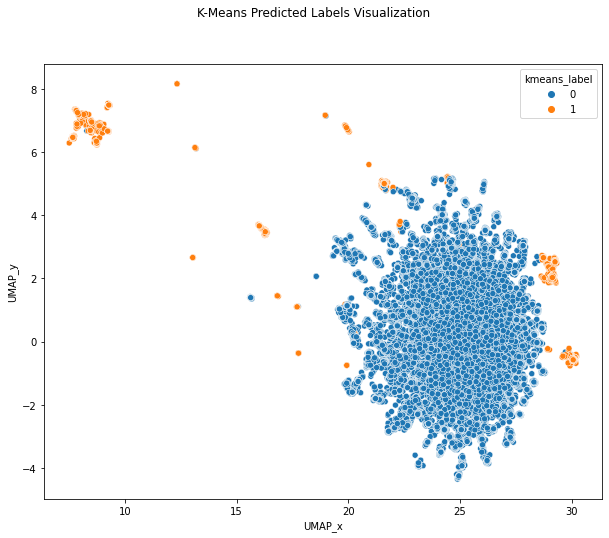

In [47]:

#fig, axes = plt.subplots(nrows=1, ncols=2,  figsize=(12,6))
plt.figure(figsize=(10,8))
plt.suptitle("K-Means Predicted Labels Visualization")
for i, label in enumerate(decomposition_model_labels):
    sns.scatterplot(x=data_2d[label+'_x'], y=data_2d[label+'_y'], hue=data_2d['kmeans_label'])
    #axes[i].set_title(label) 

**Use cluster labels**

In [48]:

dataset2 = Dataset()
dataset2.fit(users=(transactions_df_sample.customer_id.values),
             items=(transactions_df_sample.article_id.values),
             user_features=(kmeans_labels2),
             item_features=(item_features.index_group_no.values)
            )


(interactions, weights) = dataset2.build_interactions((line
    for line in zip(transactions_df_sample.customer_id.values, transactions_df_sample.article_id.values)))

print(repr(interactions))

<51527x19294 sparse matrix of type '<class 'numpy.int32'>'
	with 194000 stored elements in COOrdinate format>


In [49]:
#dataset2.mapping()[0]

In [50]:
users = list(dataset2.mapping()[0].keys())
len(items)

19294

In [51]:
user_features_bld = dataset2.build_user_features([(user, [feature]) for user, feature  
                                                 in zip (users, kmeans_labels2)])

print(repr(item_features_bld))

<19294x19299 sparse matrix of type '<class 'numpy.float32'>'
	with 38588 stored elements in Compressed Sparse Row format>


In [52]:
item_features_bld = dataset2.build_item_features([(article_id, [feature]) for article_id, feature  
                                                 in zip(item_features.article_id.values, item_features.index_group_no.values)])

print(repr(item_features_bld))

<19294x19299 sparse matrix of type '<class 'numpy.float32'>'
	with 38588 stored elements in Compressed Sparse Row format>


In [53]:
# Make split
train_sp, valid_sp = random_train_test_split(interactions, test_percentage=0.1, random_state=42)

In [54]:
model4 = LightFM(no_components=30, loss='warp', random_state=42)
model4.fit(train_sp, epochs=40, num_threads=2)
print("Train AUC: %.4f" % auc_score(model4, train_sp).mean())
print("Valid AUC: %.4f" % auc_score(model4, valid_sp).mean())


Train AUC: 0.9998
Valid AUC: 0.8187


In [55]:
model3 = LightFM(no_components=30, loss='warp', random_state=42)
model3.fit(train_sp, user_features=user_features_bld, epochs=40, num_threads=2)
print("Train AUC: %.4f" % auc_score(model3, train_sp, user_features=user_features_bld).mean())
print("Valid AUC: %.4f" % auc_score(model3, valid_sp, user_features=user_features_bld).mean())


Train AUC: 0.9634
Valid AUC: 0.8372


In [56]:
model5 = LightFM(no_components=30, loss='warp', random_state=42)
model5.fit(train_sp, user_features=user_features_bld, item_features=item_features_bld, epochs=50, num_threads=2)
print("Train AUC: %.4f" % auc_score(model5, train_sp, user_features=user_features_bld, item_features=item_features_bld).mean())
print("Valid AUC: %.4f" % auc_score(model5, valid_sp, user_features=user_features_bld, item_features=item_features_bld).mean())


Train AUC: 0.9453
Valid AUC: 0.8800


In [57]:
model6 = LightFM(no_components=30, loss='warp', random_state=42)
model6.fit(train_sp, item_features=item_features_bld, epochs=40, num_threads=2)
print("Train AUC: %.4f" % auc_score(model6, train_sp, item_features=item_features_bld).mean())
print("Valid AUC: %.4f" % auc_score(model6, valid_sp, item_features=item_features_bld).mean())


Train AUC: 0.9834
Valid AUC: 0.8671


In [58]:
lightfm_plus_plus_preds = sample_recommendation(model5,
                                  transactions_df_sample,
                                  articles_df.set_index("article_id"),
                                  24,
                                  items, 
                                  dataset,
                                  customer_test_df.customer_id.values,
                                  user_features=user_features_bld,
                                  item_features=item_features_bld,
                                  printfile='log2.txt'
                                  )

In [59]:

with open('lightfm_plus_plus_preds', 'wb') as fp:
    pickle.dump(lightfm_plus_plus_preds, fp)

In [60]:
lightfm_metrics = metrics(ground_truth_list, lightfm_plus_plus_preds)

Interceptions: 176 from 6000 (2.933%)
Jaccard: 0.01092
Dice: 0.02072
Mean Average Precision @ 12: 0.006615
